<>:88: SyntaxWarning: invalid escape sequence '\P'
<>:88: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Y.A\AppData\Local\Temp\ipykernel_19600\379061524.py:88: SyntaxWarning: invalid escape sequence '\P'
  plt.title(f"Distribution of $\Phi$ in {city}")


--------- City:  Bucharest, Romania


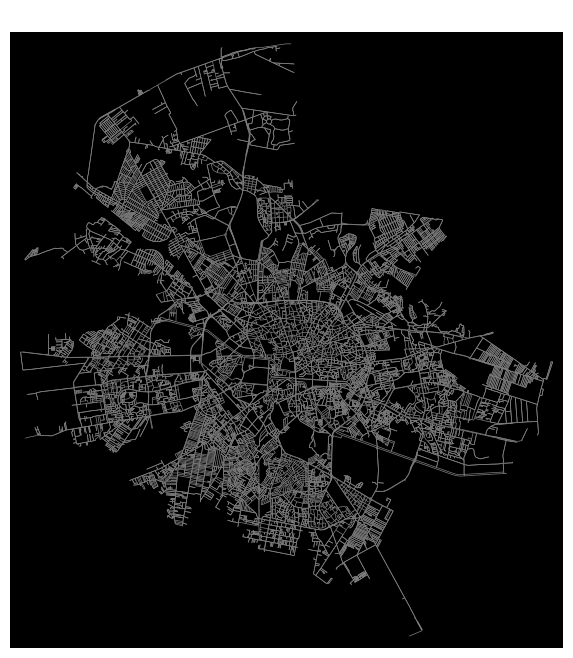

Number of faces in Bucharest, Romania: 7476


Processing faces for Bucharest, Romania: 100%|██████████| 7476/7476 [00:05<00:00, 1329.24it/s]


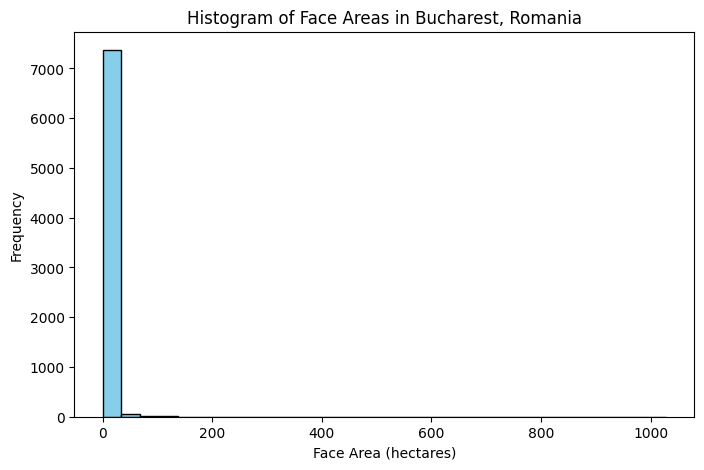

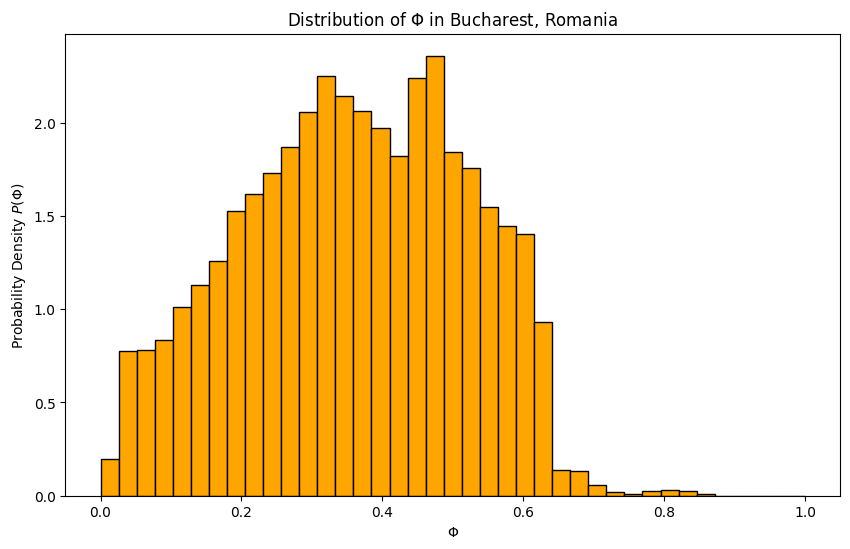

In [1]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString
from shapely.ops import polygonize
import numpy as np
from tqdm import tqdm

# List of cities to analyze
cities = ['Bucharest, Romania']
phi_values = []
all_face_areas = {}

for city in cities:
    # Download road network
    #G = ox.graph_from_place(city, network_type='drive')

    print('--------- City: ',city)
    if city == "Paris, France":
        G = ox.graph_from_place("Le Marais, Paris, France", network_type="drive")  # A specific area
    else:
        G = ox.graph_from_place(city, network_type="drive")  # Default for full city


    # Plot the road network
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_facecolor('black')
    ox.plot_graph(G, ax=ax, node_size=0, edge_color='gray', edge_linewidth=0.5, show=False)
    plt.title(f"Road Network of {city}", color='white')
    plt.show()
    
    # Convert graph to undirected and extract edges as LineStrings
    G_undirected = nx.Graph(G)
    gdf_edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
    gdf_edges = gdf_edges.to_crs(epsg=3857)  # Convert to metric projection (Web Mercator)

    
    # Create a list of LineStrings representing the street edges
    edge_lines = [LineString([(G.nodes[u]['x'], G.nodes[u]['y']), (G.nodes[v]['x'], G.nodes[v]['y'])]) for u, v in G_undirected.edges()]
    
    # Extract the enclosed faces using polygonization
    faces = list(polygonize(edge_lines))
    faces = gpd.GeoSeries(faces, crs='EPSG:4326').to_crs(epsg=3857)  # Convert polygons to metric projection
    
    city_phi_values = []
    face_areas = []
    
    print(f"Number of faces in {city}: {len(faces)}")
    
    for polygon in tqdm(faces, desc=f"Processing faces for {city}"):
        A = polygon.area  # Block area
        face_areas.append(A / 10000)  # Convert m² to hectares
        
        # Compute the largest internal distance (D)
        coords = list(polygon.exterior.coords)
        max_dist = 0
        for i, p1 in enumerate(coords):
            for p2 in coords[i+1:]:
                dist = np.linalg.norm(np.array(p1) - np.array(p2))
                max_dist = max(max_dist, dist)
        D = max_dist  # Maximum distance
        
        if D > 0:
            phi = 4 * A / (np.pi * D**2)
            city_phi_values.append(phi)
    
    # Store the average phi for the city
    phi_values.append(np.mean(city_phi_values) if city_phi_values else 0)
    all_face_areas[city] = face_areas
    
    # Plot histogram of face areas
    plt.figure(figsize=(8, 5))
    plt.hist(face_areas, bins=30, color='skyblue', edgecolor='black')
    plt.xlabel("Face Area (hectares)")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of Face Areas in {city}")
    plt.show()

    # Plot distribution of phi P(phi)
    plt.figure(figsize=(10, 6))
    bins = np.linspace(0, 1, 40)
    plt.hist(city_phi_values, bins=bins, color='orange', edgecolor='black', density=True)
    #plt.xscale('log')
    #plt.yscale('log')
    plt.xlabel(r"$\Phi$")
    plt.ylabel(r"Probability Density $P(\Phi)$")
    plt.title(f"Distribution of $\Phi$ in {city}")
    plt.show()


